In [1]:
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as graph

from datetime import datetime
from IPython.display import display
from pandas.tseries.offsets import *

from sklearn.externals import joblib
from sklearn.preprocessing import StandardScaler
from sklearn.neighbors import KNeighborsRegressor
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.model_selection import train_test_split, GridSearchCV

from keras.losses import mse
from keras.callbacks import EarlyStopping
from keras.optimizers import Adam, rmsprop
from keras.models import Sequential, load_model
from keras.layers import Dense, Dropout, Activation

sns.set_style('whitegrid')

/home/harshil/miniconda3/lib/python3.6/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


# Read data

In [2]:
train = pd.read_csv('Data/train.csv')
test = pd.read_csv('Data/test.csv')

print('Train')
display(train.info())
display(train.head())
display(train.tail())

print('Test')
display(train.info())
display(test.head())
display(test.tail())

Train
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


None

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
0,1/1/2011 0:00,1,0,0,1,9.84,14.395,81,0.0,3,13,16
1,1/1/2011 1:00,1,0,0,1,9.02,13.635,80,0.0,8,32,40
2,1/1/2011 2:00,1,0,0,1,9.02,13.635,80,0.0,5,27,32
3,1/1/2011 3:00,1,0,0,1,9.84,14.395,75,0.0,3,10,13
4,1/1/2011 4:00,1,0,0,1,9.84,14.395,75,0.0,0,1,1


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed,casual,registered,count
10881,12/19/2012 19:00,4,0,1,1,15.58,19.695,50,26.0027,7,329,336
10882,12/19/2012 20:00,4,0,1,1,14.76,17.425,57,15.0013,10,231,241
10883,12/19/2012 21:00,4,0,1,1,13.94,15.910,61,15.0013,4,164,168
10884,12/19/2012 22:00,4,0,1,1,13.94,17.425,61,6.0032,12,117,129
10885,12/19/2012 23:00,4,0,1,1,13.12,16.665,66,8.9981,4,84,88


Test
<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10886 entries, 0 to 10885
Data columns (total 12 columns):
datetime      10886 non-null object
season        10886 non-null int64
holiday       10886 non-null int64
workingday    10886 non-null int64
weather       10886 non-null int64
temp          10886 non-null float64
atemp         10886 non-null float64
humidity      10886 non-null int64
windspeed     10886 non-null float64
casual        10886 non-null int64
registered    10886 non-null int64
count         10886 non-null int64
dtypes: float64(3), int64(8), object(1)
memory usage: 1020.6+ KB


None

,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
0,1/20/2011 0:00,1,0,1,1,10.66,11.365,56,26.0027
1,1/20/2011 1:00,1,0,1,1,10.66,13.635,56,0.0000
2,1/20/2011 2:00,1,0,1,1,10.66,13.635,56,0.0000
3,1/20/2011 3:00,1,0,1,1,10.66,12.880,56,11.0014
4,1/20/2011 4:00,1,0,1,1,10.66,12.880,56,11.0014


,datetime,season,holiday,workingday,weather,temp,atemp,humidity,windspeed
6488,12/31/2012 19:00,1,0,1,2,10.66,12.880,60,11.0014
6489,12/31/2012 20:00,1,0,1,2,10.66,12.880,60,11.0014
6490,12/31/2012 21:00,1,0,1,1,10.66,12.880,60,11.0014
6491,12/31/2012 22:00,1,0,1,1,10.66,13.635,56,8.9981
6492,12/31/2012 23:00,1,0,1,1,10.66,13.635,65,8.9981


#### No null values in the dataset but a few rows are missing from the training set

# Format data

In [3]:
datasets = [train, test]

for dataset in datasets:
    # Format datetime from string to datetime collumn and set as index
    dataset['datetime'] = pd.to_datetime(dataset['datetime'], format='%m/%d/%Y %H:%M')
    dataset.set_index(dataset['datetime'], inplace=True)
    
    # Create timeperiod collumns
    dataset['weekday'] = dataset.apply(lambda row: row.name.weekday(), axis=1)
    dataset['hour'] = dataset.apply(lambda row: row.name.hour, axis=1)
    dataset['day_of_year'] = dataset.apply(lambda row: row.name.dayofyear, axis=1)
    dataset['year'] = dataset.apply(lambda row: row.name.year, axis=1)
    dataset['month'] = dataset.apply(lambda row: row.name.month, axis=1)
    
    # Column to identify non-missing rows
    dataset['is_missing'] = False
    
# Remove unneeded columns
train.drop(['datetime', 'casual', 'registered'], axis=1, inplace=True)

### Impute missing rows
#### Fill missing rows between 2011 and 2012 that should be in the dataset but aren't in either training or test set

In [4]:
%%time
# Impute weather for missing hours
def get_prev_timepoint(missing_time):
    return missing_time - DateOffset(hours = 1)


def get_next_timepoint(missing_time):
    return missing_time + DateOffset(hours = 1)


def get_existing_times(missing_time, df, get_timepoint):
    
    running_time = get_timepoint(missing_time)
    exist = pd.DataFrame()
    
    while True:   
        if running_time in df.index:
            exist = exist.append(df.loc[running_time])
            return exist
        else:
            running_time = get_timepoint(running_time)

            
def get_imputation(missing_time, df):
    
    prev_times = get_existing_times(missing_time, df, get_prev_timepoint)
    next_times = get_existing_times(missing_time, df, get_next_timepoint)
    times = prev_times.append(next_times)
    
    imputed_row = pd.DataFrame(index = [missing_time])
   
    imputed_row['count'] = 0
    imputed_row['is_missing'] = True
    imputed_row['hour'] = missing_time.hour
    imputed_row['year'] = missing_time.year
    imputed_row['month'] = missing_time.month
    imputed_row['weekday'] = missing_time.weekday()
    imputed_row['day_of_year'] = missing_time.dayofyear
    
    imputed_row['temp'] = np.mean(times.temp)
    imputed_row['atemp'] = np.mean(times.atemp)
    imputed_row['humidity'] = np.mean(times.humidity)
    imputed_row['windspeed'] = np.mean(times.windspeed)
    imputed_row['season'] = round(np.mean(times.season))
    imputed_row['holiday']= round(np.mean(times.holiday))
    imputed_row['weather'] = round(np.mean(times.weather))
    imputed_row['workingday'] = bool(len(pd.bdate_range(missing_time, missing_time)))

    return(imputed_row)


def hour_not_exist(time, df):
    if time in df.index:
        return(0)
    else:
        return(1)
    
    
def get_hours_not_exist(df):
    #Generate time range with only first 19 days of each month
    time_range = np.array([], dtype = 'datetime64[ns]')
    time_range_months_start = pd.date_range(df.head()[:1].index[0],df.tail()[4:].index[0], freq = "MS")
    
    for time in time_range_months_start:
        first_19_days = pd.date_range(time, time + DateOffset(days = 18, hours = 23), freq = 'h')
        time_range = np.append(time_range, first_19_days)
    
    time_range = pd.DatetimeIndex(time_range)
    
    hours_not_exist_bool = np.array(time_range.map(lambda time: hour_not_exist(time, df)),dtype = 'bool')
    hours_not_exist = time_range[hours_not_exist_bool]
    
    return hours_not_exist

hours_not_exist_train = get_hours_not_exist(train)

for hour in hours_not_exist_train:
    imputed_row = get_imputation(hour, train)
    train = train.append(imputed_row)

train = train.loc[train.index.sort_values()]

CPU times: user 1.76 s, sys: 8 ms, total: 1.76 s
Wall time: 1.77 s


#### Split training set to make a second test set to evaluate model before we test on the final test set

In [5]:
df, df_test = train_test_split(
    train, 
    test_size=0.25, 
    random_state=42)

print(df.shape, df_test.shape)

(8208, 15) (2736, 15)


# Data Visualization

,atemp,count,day_of_year,holiday,hour,humidity,month,season,temp,weather,weekday,windspeed,workingday,year
count,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000,8208.000000
mean,23.557462,191.240863,177.350024,0.026559,11.429459,61.880147,6.514742,2.503411,20.150394,1.416545,3.018884,12.827499,0.681165,2011.500609
std,8.502326,182.504237,105.304064,0.160802,6.925839,19.248366,3.453149,1.120057,7.814551,0.631880,2.007118,8.240376,0.466053,0.500030
min,0.760000,0.000000,1.000000,0.000000,0.000000,0.000000,1.000000,1.000000,0.820000,1.000000,0.000000,0.000000,0.000000,2011.000000
25%,16.665000,40.000000,91.000000,0.000000,5.000000,47.000000,4.000000,2.000000,13.940000,1.000000,1.000000,7.001500,0.000000,2011.000000
50%,24.240000,144.000000,182.000000,0.000000,11.000000,62.000000,7.000000,3.000000,20.500000,1.000000,3.000000,12.998000,1.000000,2012.000000
75%,31.060000,285.000000,275.000000,0.000000,17.000000,77.000000,10.000000,4.000000,26.240000,2.000000,5.000000,16.997900,1.000000,2012.000000
max,45.455000,970.000000,354.000000,1.000000,23.000000,100.000000,12.000000,4.000000,39.360000,4.000000,6.000000,56.996900,1.000000,2012.000000


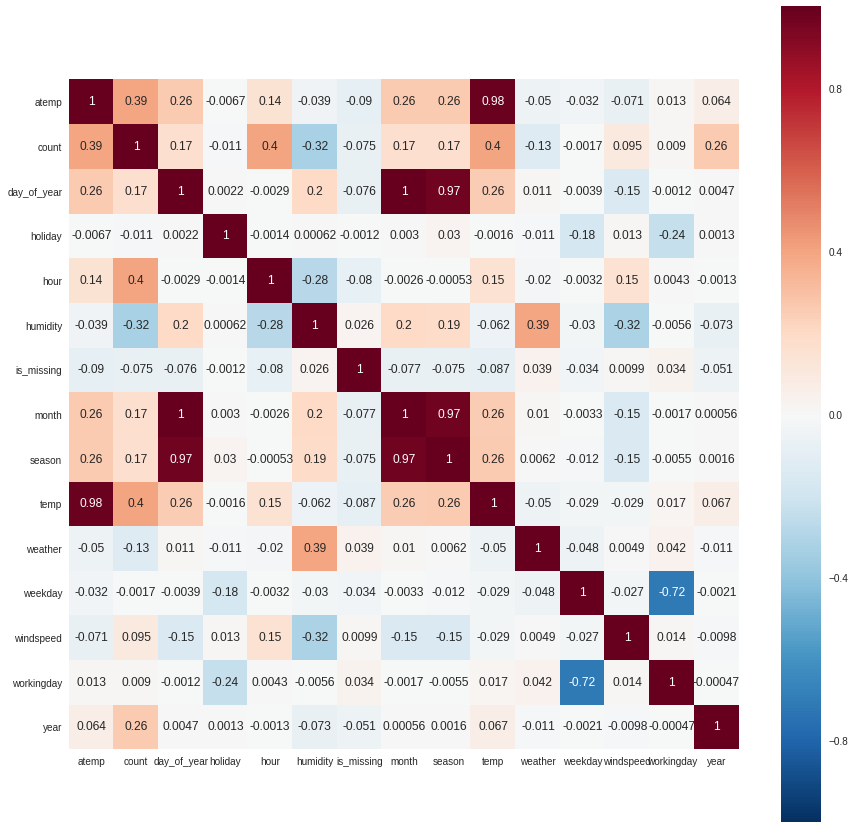

In [6]:
# Summary statistics

display(df.describe())

graph.figure(figsize=(15, 15))
sns.heatmap(df.corr(), square=True, annot=True)
graph.show()

#### Quite a few of our variables are correlated

#### with count specifically: atemp, day of year, hour, humidity, month, season, weather, and year
#### Some features such as temp and atemp are highly correlated such that one of the two is enough for the models


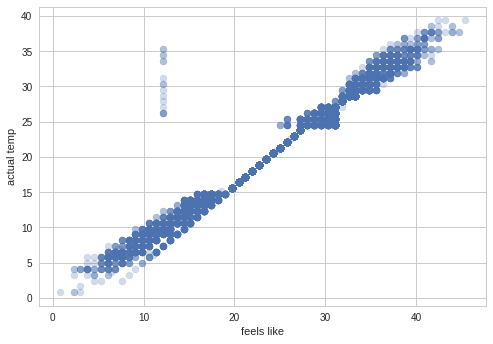

In [7]:
# Correlation between actual temperature and feels like temperature

graph.scatter(df['atemp'], df['temp'], alpha=0.25)
graph.xlabel('feels like')
graph.ylabel('actual temp')
graph.show()

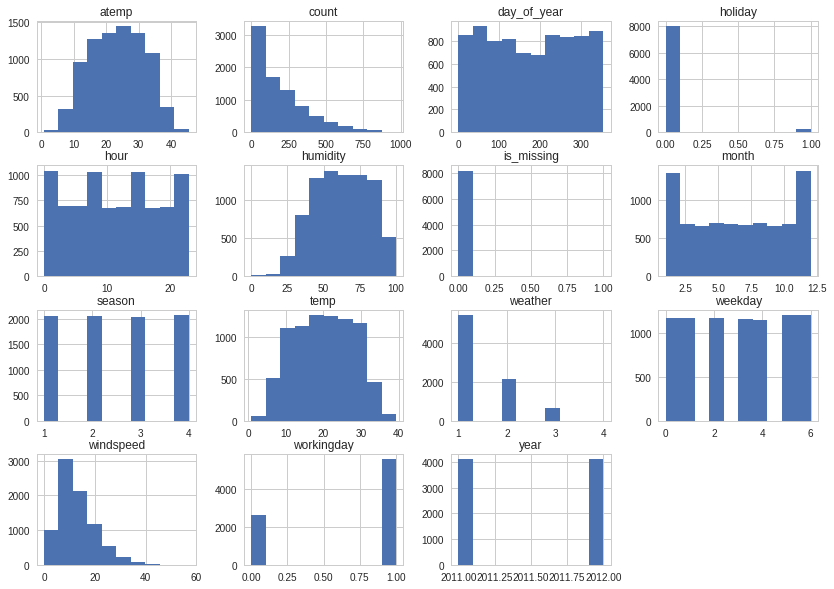

In [8]:
# Variable distributions

df.hist(figsize=(14,10))
graph.show()

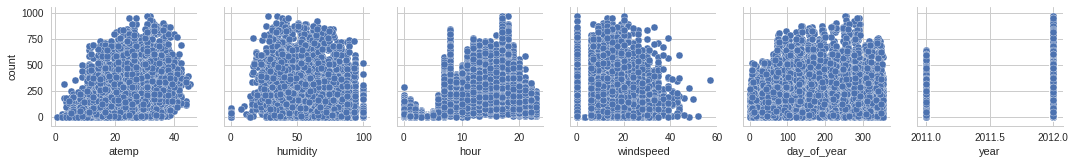

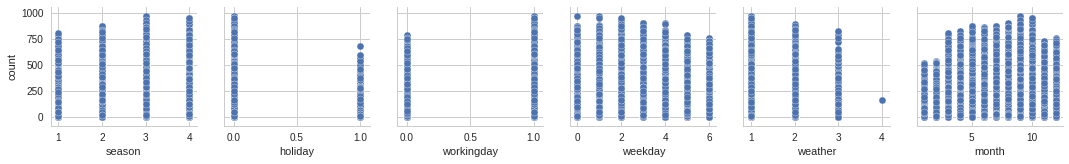

In [9]:
# Scatter plots between count and some variables 

sns.pairplot(
    df,
    y_vars = ['count'],
    x_vars=['atemp', 'humidity', 'hour', 'windspeed', 'day_of_year', 'year'],
)

sns.pairplot(
    df,
    y_vars = ['count'],
    x_vars=['season', 'holiday', 'workingday', 'weekday', 'weather', 'month'],
)

graph.show()

#### There seems to be some visually discernible trend between count and a few of these variables

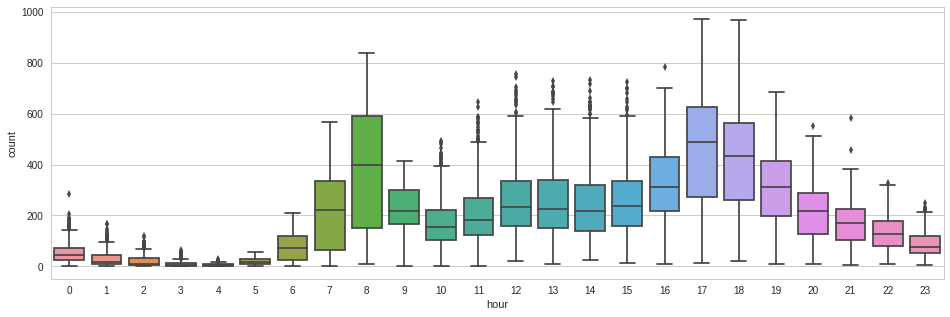

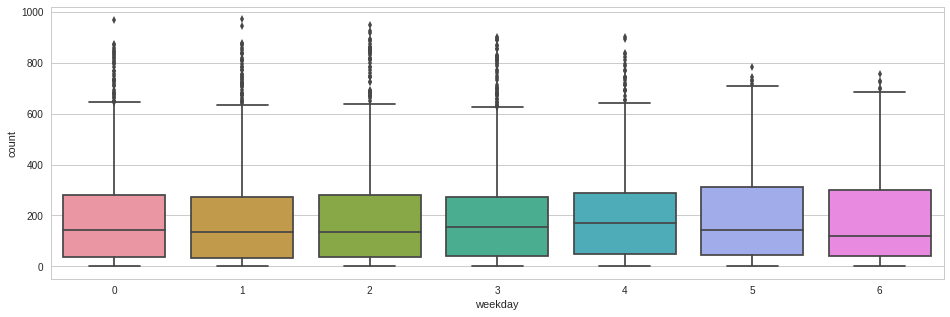

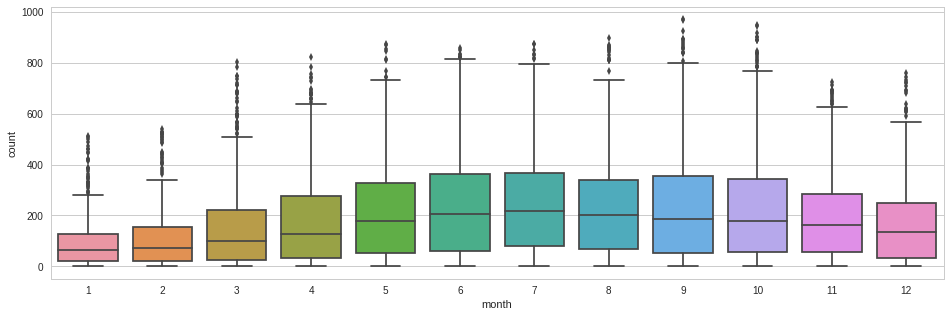

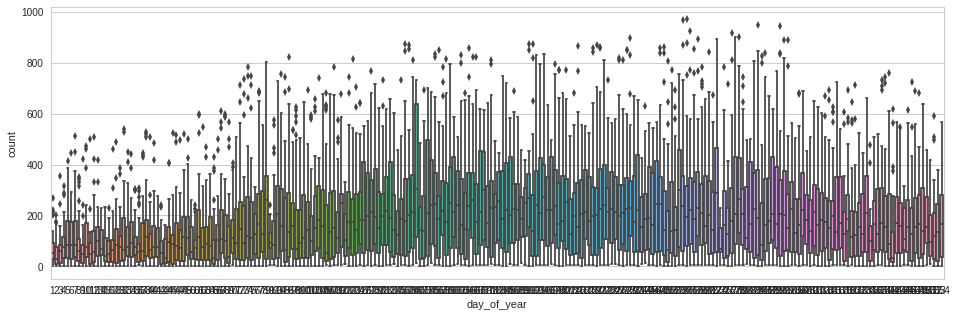

In [10]:
# How does time of day affect kayak rental?

for time in ['hour', 'weekday', 'month', 'day_of_year']:
    graph.figure(figsize=(16, 5))
    sns.boxplot(x=time, y='count', data=df)
    graph.show()

# Modeling

### Prep training set

In [11]:
predictors = ['humidity', 'temp', 'weekday', 'atemp', 'workingday', 'day_of_year', 'year', 'hour']
knn_predictors = ['hour', 'workingday', 'day_of_year', 'year']

# Separate the y and predictors

data = df.copy()

y = data.pop('count').values
x = data[predictors].values
x_knn = data[knn_predictors].values

# Standardize the variables 

scaler = StandardScaler().fit(y)
y_standardized = scaler.transform(y)

scaler = StandardScaler().fit(x)
x_standardized = scaler.transform(x)

scaler = StandardScaler().fit(x_knn)
x_knn_standardized = scaler.transform(x_knn)

print(y_standardized.shape, x_standardized.shape, x_knn_standardized.shape)

(8208,) (8208, 8) (8208, 4)


/home/harshil/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/harshil/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/harshil/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


### Prep Test set

In [12]:
data_test = df_test.copy()

# Separate the y and predictors

y_test = data_test.pop('count').values
x_test = data_test[predictors].values
x_test_knn = data_test[knn_predictors].values

# Standardize the variables 

scaler = StandardScaler().fit(y_test)
y_test_standardized = scaler.transform(y_test)

scaler = StandardScaler().fit(x_test)
x_test_standardized = scaler.transform(x_test)

scaler = StandardScaler().fit(x_test_knn)
x_test_knn_standardized = scaler.transform(x_test_knn)

print(y_test_standardized.shape, x_test_standardized.shape, x_test_knn_standardized.shape)

(2736,) (2736, 8) (2736, 4)


/home/harshil/miniconda3/lib/python3.6/site-packages/sklearn/utils/validation.py:429: DataConversionWarning: Data with input dtype int64 was converted to float64 by StandardScaler.
  warnings.warn(msg, _DataConversionWarning)
/home/harshil/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:586: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)
/home/harshil/miniconda3/lib/python3.6/site-packages/sklearn/preprocessing/data.py:649: DeprecationWarning: Passing 1d arrays as data is deprecated in 0.17 and will raise ValueError in 0.19. Reshape your data either using X.reshape(-1, 1) if your data has a single feature or X.reshape(1, -1) if it contains a single sample.
  warnings.warn(DEPRECATION_MSG_1D, DeprecationWarning)


### K Nearest Neighbour

In [13]:
gridsearch_knn = GridSearchCV(
    estimator=KNeighborsRegressor(), 
    param_grid={
        'n_neighbors': list(range(1, 40, 3)),
        'weights': ['distance']
    },
    n_jobs=-1,
    cv=5    
)

gridsearch_knn.fit(x_knn_standardized, y_standardized)
print(gridsearch_knn.best_score_)
print(gridsearch_knn.best_params_)

0.885232274625
{'n_neighbors': 13, 'weights': 'distance'}


### RandomForest

In [14]:
gridsearch_rf = GridSearchCV(
    estimator=RandomForestRegressor(),
    param_grid=({
        'n_estimators': range(300, 600, 50), 
        'max_depth': range(6, 9),
        'min_samples_split': range(7, 10),
    }),
    n_jobs=-1,
    cv=5,
)

gridsearch_rf.fit(x_standardized, y_standardized)
print(gridsearch_rf.best_score_)
print(gridsearch_rf.best_params_)

0.886193795699
{'max_depth': 8, 'min_samples_split': 7, 'n_estimators': 500}


### NeuralNetwork

0.102572398188


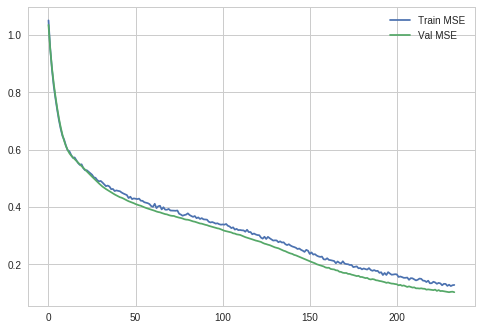

In [15]:
dnn = Sequential()

dnn.add(Dense(32, activation='relu', input_shape=(x.shape[1], )))
dnn.add(Dropout(0.1))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dense(32, activation='relu'))
dnn.add(Dense(1, activation='linear'))

dnn.compile(optimizer='adam', loss='mse')

hist = dnn.fit(
    x_standardized, y_standardized,
    validation_split=0.33,
    epochs=5000, batch_size=2048, 
    verbose=0, 
    callbacks=[EarlyStopping(monitor='val_loss', min_delta=0, patience=2)]
)

print(hist.history['val_loss'][-1])

graph.plot(hist.history['loss'], label='Train MSE')
graph.plot(hist.history['val_loss'], label='Val MSE')
graph.legend()
graph.show()

### Model Predictions

In [16]:
knn_prediction = gridsearch_knn.predict(x_test_knn_standardized)
rf_prediction = gridsearch_rf_predict = gridsearch_rf.predict(x_test_standardized)
dnn_prediction = dnn.predict(x_test_standardized)

### Calculate mse and r2 on test set

In [17]:
# Mean Squared Errors on test set

knn_mse = mean_squared_error(y_test_standardized, knn_prediction)
rf_mse = mean_squared_error(y_test_standardized, rf_prediction)
dnn_mse = mean_squared_error(y_test_standardized, dnn_prediction)

# R2 on test set

knn_r2 = r2_score(y_test_standardized, knn_prediction)
rf_r2 = r2_score(y_test_standardized, rf_prediction)
dnn_r2 = r2_score(y_test_standardized, dnn_prediction)

model_names = ['knn', 'rf', 'dnn']
model_mses = [knn_mse, rf_mse, dnn_mse]
model_r2s = [knn_r2, rf_r2, dnn_r2]

### Display mse and r2 results

knn
mse:  0.132195996061
r2:  0.867804003939

rf
mse:  0.113698453573
r2:  0.886301546427

dnn
mse:  0.122494409217
r2:  0.877505590783



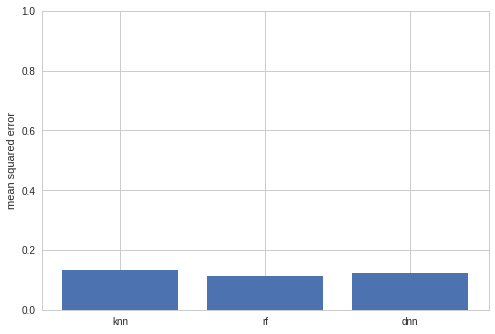

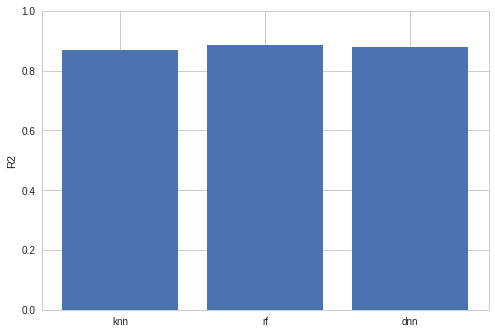

In [18]:
for model_name, model_mse, model_r2 in zip(model_names, model_mses, model_r2s):
    print(model_name)
    print('mse: ', model_mse)
    print('r2: ', model_r2)
    print()

bar_pos = range(3)

graph.bar(bar_pos, model_mses)
graph.ylabel('mean squared error')
graph.ylim(0, 1)
graph.xticks(bar_pos, model_names)
graph.show()

graph.bar(bar_pos, model_r2s)
graph.ylabel('R2')
graph.ylim(0, 1)
graph.xticks(bar_pos, model_names)
graph.show()

### Save Models

In [19]:
joblib.dump(gridsearch_knn, 'gridsearch_knn_kayak.pkl')
joblib.dump(gridsearch_rf, 'gridsearch_rf_kayak.pkl')
dnn.save('dnn_kayak.h5')

### Load models for use

In [20]:
blah = joblib.load('gridsearch_knn_kayak.pkl')
blah2 = joblib.load('gridsearch_rf_kayak.pkl')
blah3 = load_model('dnn_kayak.h5')